# Movie recommender
Program na podstawie zadanego tytułu filmu szuka podobnych, przy czym podobieństwo jest badane na podstawie opisów </br></br>
Autorzy:
<ul>
    <li>Zuzanna Chodorowska,</li>
    <li>Nikodem Kaczmarek,</li>
    <li>Wojciech Kargel,</li>
    <li>Milena Surman,</li>
    <li>Patryk Garwol</li>

<hr style="border-top: 2px dashed white">

### Zebranie danych
Za jedyne źródło danych posłużył dataset <a href="https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset" target="_blank">*The Movies Dataset*</a> ze strony *kaggle.com*. </br>
Posiada ponad 45 000 rekordów z przeróżnymi informacjami na temat filmów. W tym przypadku istotne będą jedynie kolumny z **tytułami** i **opisami**.
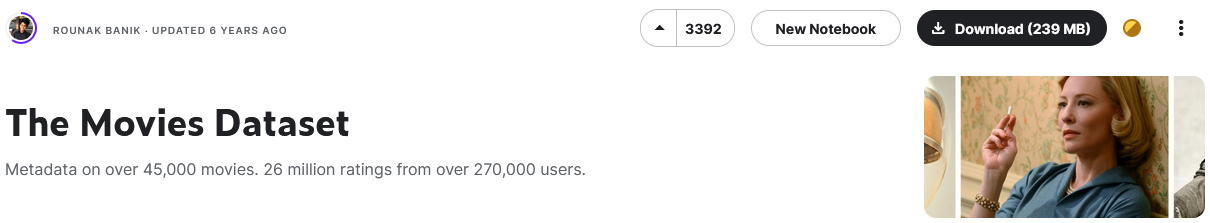

<hr style="border-top: 2px dashed white">

## Import modułów
Najważniejsze moduły wykorzystywane w projekcie:
* **numpy, pandas** - gromadzenie i porządkowanie danych
* **matplotlib.pyplot** - wizualizacja danych
* **sklearn (z pakietu scikit-learn)** - rozbudowane narzędzie do m.in *machine learningu*

In [1]:
import warnings
from typing import List
import pandas as pd
import spacy
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

<hr style="border-top: 2px dashed white">

## Praca z danymi

#### Wczytanie danych

In [2]:
movies = pd.read_csv('movies_metadata.csv', low_memory=False)
print(movies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

#### Pozostawienie przydatnych kolumn

In [3]:
movies = movies[['title', 'overview', 'imdb_id', 'popularity']]
movies = movies.sort_values(by='popularity', ascending=False)
movies.head(3)

,title,overview,imdb_id,popularity
35587,NaN,Released,0,Beware Of Frost Bites
38576,Hyper Sapien: People from Another Star,Three aliens from the planet Taros land on Ear...,tt0091238,9e-06
34313,Chameli Ki Shaadi,"Charandas, a young man in a village has no aim...",tt0090812,9e-06


#### Problem filmów o tym samym tytule
Rozwiązanie: gdy zostanie wpisany film, którgo tytuł ma kilka wystąpień, wybieramy najpopularniejszy.</br>
Dlatego komórkę wyżej sortowaliśmy po poularności.

In [4]:
movies[movies['title'] == 'Titanic']

,title,overview,imdb_id,popularity
25473,Titanic,A story of the romances of two couples upon th...,tt0115392,3.435807
1639,Titanic,"84 years later, a 101-year-old woman named Ros...",tt0120338,26.88907
3285,Titanic,"Unhappily married, Julia Sturges decides to go...",tt0046435,12.90707


#### Preprocessing danych
Usuniemy rekordy z pustymi wartościami, oraz duplikaty.

In [5]:
movies.dropna(inplace=True)  # None values

In [6]:
duplicates = movies.duplicated(subset=['title', 'imdb_id'], keep=False)
duplicates_df = movies[duplicates].sort_values(by='title')\
                                .copy()\
                                .reset_index(drop=True)
                                
print(duplicates_df.shape)
duplicates_df.head()

(59, 4)


,title,overview,imdb_id,popularity
0,A Farewell to Arms,British nurse Catherine Barkley (Helen Hayes) ...,tt0022879,1.914697
1,A Farewell to Arms,British nurse Catherine Barkley (Helen Hayes) ...,tt0022879,2.411191
2,A Place at the Table,"Using personal stories, this powerful document...",tt1736049,0.501046
3,A Place at the Table,"Using personal stories, this powerful document...",tt1736049,1.673307
4,Black Gold,"On the Arabian Peninsula in the 1930s, two war...",tt1701210,6.652197


In [7]:
movies.drop_duplicates(subset=['title', 'imdb_id'], keep='first', inplace=True)
movies[movies.title == 'A Farewell to Arms']

,title,overview,imdb_id,popularity
15074,A Farewell to Arms,British nurse Catherine Barkley (Helen Hayes) ...,tt0022879,2.411191


#### Usuwamy znaki interpunkcyjne, zmieniamy wszystko na małe litery oraz słowa w opisie zastępujemy oryginalną formą słów, żeby wyniki były dokładniejsze.
#### Wyrzucamy także słowa zbędne, np: (na, w, oraz, lub itd.)

In [8]:
nlp = spacy.load('en_core_web_md', disable=["ner", "parser"])

def lemmatize(line: str) -> str:
    tokens = []
    if isinstance(line, str):
        doc = nlp(line)
        tokens = [
            token.lemma_.lower()
            for token in doc
            if token.text.isalnum()
        ]

        return ' '.join(tokens)
    else:
        return ''
    
movies['overview_punctuationless'] = movies['overview'].apply(lemmatize)

<hr style="border-top: 2px dashed white">

## Sposoby porównywania opisów

#### 1. Wektor Tf-idf 
**Tf-idf** Term Frequency-Inverse Document Frequency - technika używana w NLP.
Mierzy ważność słów w kontekście dokumentu w zbiorze dokumentów.

**TF (Term Frequency)**: Mierzy, jak często dany termin występuje w dokumencie. Jest to stosunek liczby wystąpień danego słowa do liczby wszystkich słów w dokumencie. </br>
$$ 
\begin{align}
\frac{\text{Wystapienie słowa}}{\text{Liczba słów w dokumencie}}
\end{align}
$$

**IDF (Inverse Document Frequency)**: Określa, jak istotne jest dane słowo w kontekście całego zbioru dokumentów. Wartość IDF rośnie, gdy słowo występuje rzadko we wszystkich dokumentach w zbiorze. </br>
$$ 
\begin{align}
\log(\frac{\text{W ilu dokumentach wystąpiło słowo}}{\text{Liczba dokumentów}})
\end{align}
$$


In [9]:
tfidf_vect = TfidfVectorizer(stop_words='english', max_df = 0.7)
tfidf_matrix = tfidf_vect.fit_transform(movies['overview_punctuationless'].values)

#### 2. Podobieństwo cosiunowe (Cosine similarity)
Podobieństwo cosinusowe (cosine similarity) to miara używana w analizie tekstu do oceny stopnia podobieństwa między dwoma wektorami reprezentującymi teksty.
Mierzy kąt między tymi wektorami w wielowymiarowej przestrzeni, przy czym niższy kąt oznacza większe podobieństwo. </br>
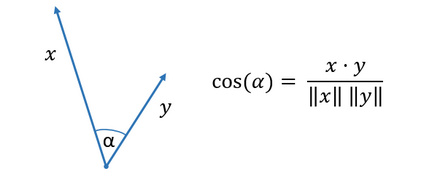

In [10]:
cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
print(f'Rows: {cosine_sim_matrix.shape[0]}, columns: {cosine_sim_matrix.shape[1]}')
movies_cosine = pd.DataFrame(
    cosine_sim_matrix, index=movies["title"].values, columns=movies["title"].values
)
movies_cosine.iloc[:3, :3]

Rows: 44461, columns: 44461


,Hyper Sapien: People from Another Star,Chameli Ki Shaadi,Blade Runner
Hyper Sapien: People from Another Star,1.00000,0.000000,0.034840
Chameli Ki Shaadi,0.00000,1.000000,0.004997
Blade Runner,0.03484,0.004997,1.000000


## Jądro liniowe (Linear Kernel)
Jądro liniowe (linear kernel) to jedno z podstawowych jąder używanych w metodach maszynowego uczenia się, zwłaszcza w algorytmach SVM (Support Vector Machines). Jądro to jest używane do przekształcania danych wejściowych w przestrzeń o wyższej wymiarowości, gdzie relacje między danymi stają się bardziej liniowe. </br>
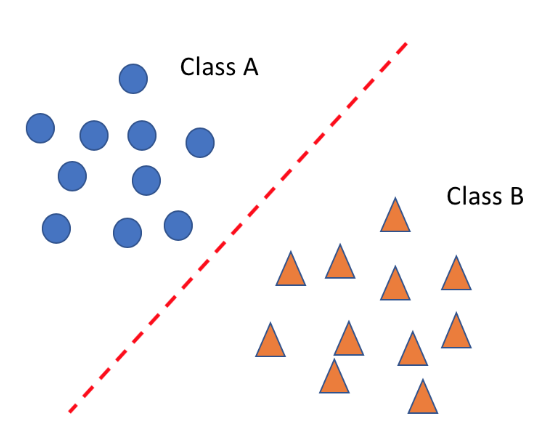

In [11]:
linear_kernel_matrix = linear_kernel(tfidf_matrix, tfidf_matrix)
print(f'Rows: {linear_kernel_matrix.shape[0]}, columns: {linear_kernel_matrix.shape[1]}')
movies_linear_k = pd.DataFrame(
    linear_kernel_matrix, index=movies["title"].values, columns=movies["title"].values
)
movies_linear_k.iloc[:3, :3]

Rows: 44461, columns: 44461


,Hyper Sapien: People from Another Star,Chameli Ki Shaadi,Blade Runner
Hyper Sapien: People from Another Star,1.00000,0.000000,0.034840
Chameli Ki Shaadi,0.00000,1.000000,0.004997
Blade Runner,0.03484,0.004997,1.000000


<hr style="border-top: 2px dashed white">

## Funkcje do wykorzystania aplikacji

#### Funkcja do wyszukiwania podobnych filmów

In [12]:
def find_similar(title: str) -> dict:
    try:
        similiarities = movies_cosine.loc[title]
    except KeyError as e:
        print(f'Nie znaleziono filmu: {e}.')
        return None
    
    # Case if more than 1 movie with the same title
    if isinstance(similiarities, pd.core.frame.DataFrame):
        similiarities = similiarities.iloc[0]  
         
    top_similar = similiarities.sort_values(ascending=False)
    top10_similar = dict(top_similar[1:11].items())
    return top10_similar

#### Funkcja, która sugeruje podobne tytuły, jeżeli input użytkownika nie zostanie odnaleziony

In [13]:
def suggest_titles(title: str) -> None:
    nlp = spacy.load('en_core_web_md', disable=["ner", "parser"])
    title_nlp = nlp(title.lower())
    similarities = []
    for _, row in movies.iterrows():
        if not isinstance(row['title'], str):
            continue
        
        compared_title = nlp(row['title'].lower())
        similarity = title_nlp.similarity(compared_title)
        similarities.append((row['title'], similarity))
        
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)[:10]
    similarities_titles_only = list(map(lambda x: x[0], similarities))
    suggestions_df = pd.DataFrame(data=similarities_titles_only, columns=['Title'])
    suggestions_df.index = suggestions_df.index + 1

    print('Być może miał(aś/eś) na myśli:')
    print(suggestions_df)

#### Funkcja do prezentacji wyników

In [14]:
def create_chart(matches: dict, title: str, savetofile: bool=False):
    matches = dict(sorted(matches.items(), key=lambda item: item[1]))
    plt.style.use('seaborn-v0_8')
    fig, ax = plt.subplots()
    
    for movie, similarity in matches.items():
        rects = ax.barh(movie, np.round(similarity*100, 2))
        ax.bar_label(rects, padding=2)

    ax.set_title(f'Najlepsze dopasowania dla filmu {title}')
    ax.set_xlabel('Zgodność opisów (%)')
    ax.set_ylabel('Znalezione filmy')

    plt.show()

    if savetofile:
        title_no_spaces = title.replace(' ', '_')
        fig.savefig(f'{title_no_spaces}_matches.jpg', bbox_inches='tight', dpi=300)

<hr style="border-top: 2px dashed white">

## Rezultat

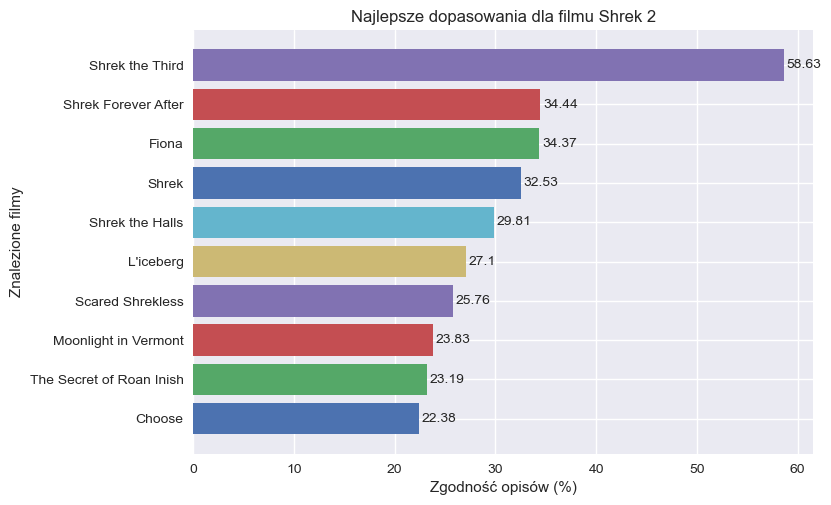

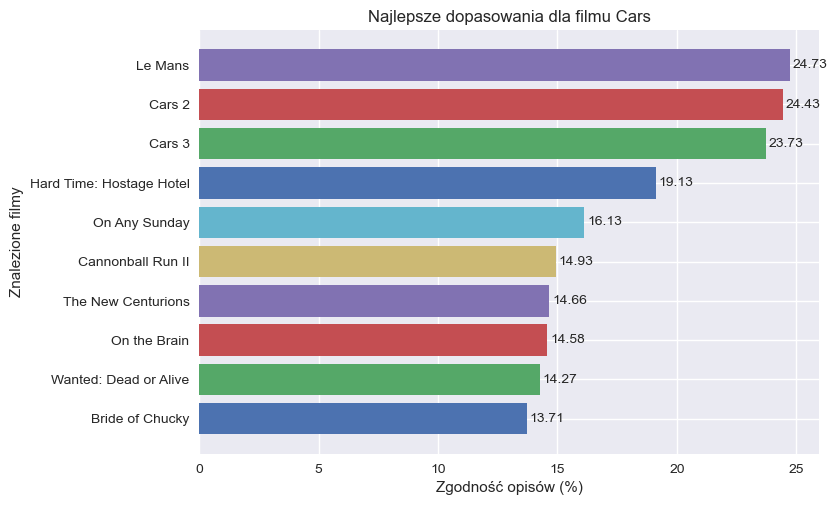

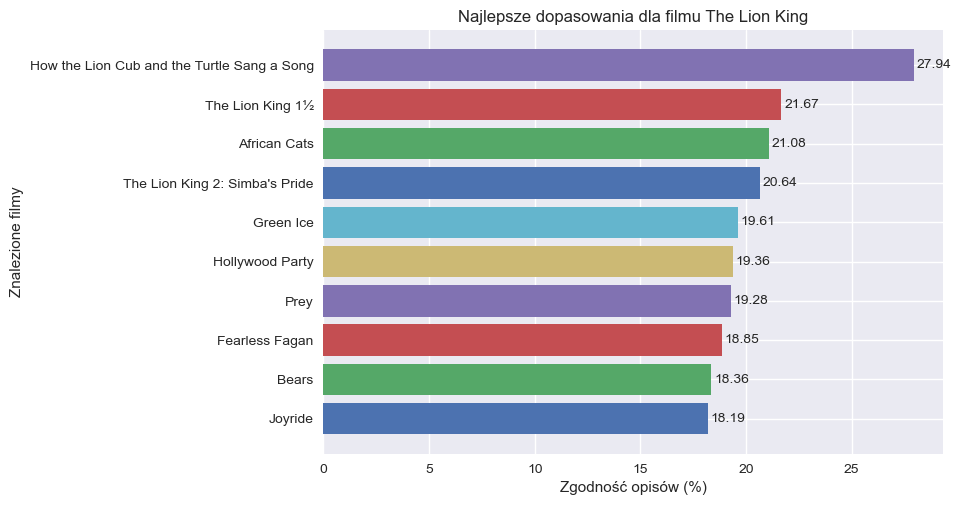

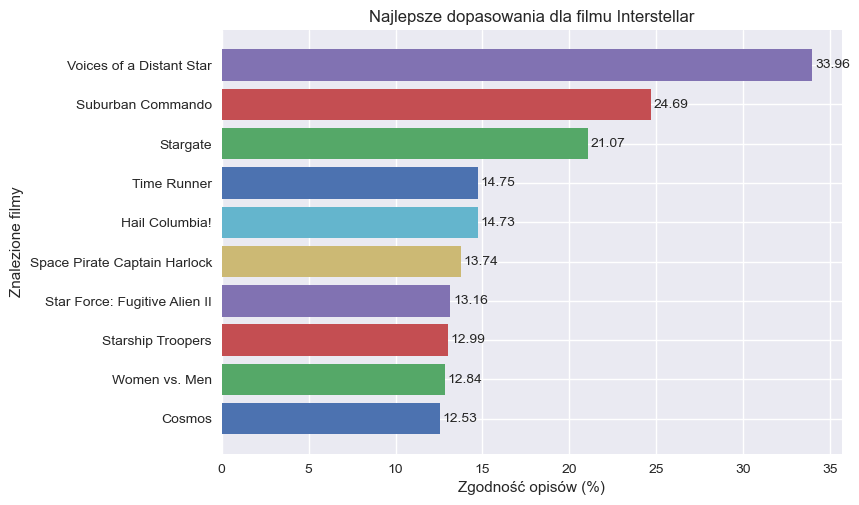

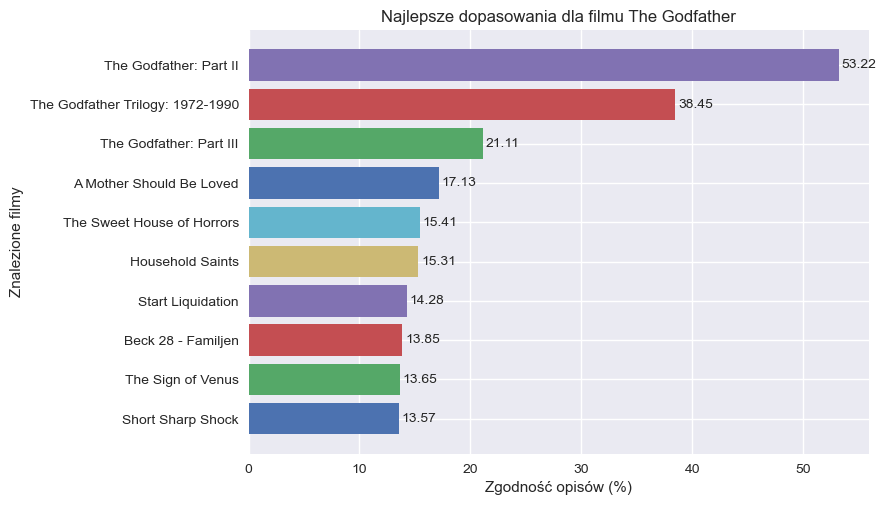

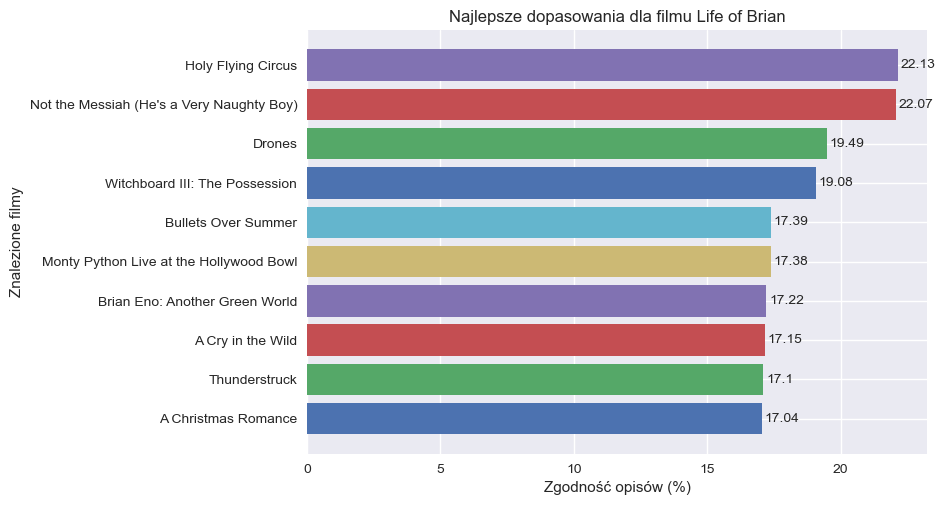

Nie znaleziono filmu: 'Lord of the Drinks'.
Być może miał(aś/eś) na myśli:
                      Title
1     The Lords of Flatbush
2         Lord of the Flies
3         Lord of the Flies
4   The Lords of Discipline
5     The Lord of the Rings
6      King of the Belgians
7         Edges of the Lord
8    The Kingdom of Fairies
9      The Kings of Mykonos
10   The Mistress of Spices


In [15]:
example_titles = (
    'Shrek 2', 'Cars', 'The Lion King', 'Interstellar', 'The Godfather', 'Life of Brian', 'Lord of the Drinks'
)
for title in example_titles:
    top_matches = find_similar(title=title)
    if top_matches:
        create_chart(matches=top_matches, title=title, savetofile=True)
    else:
        suggest_titles(title=title)

<hr style="border-top: 2px dashed white">

## Dodatkowo:

#### WordCloud

In [16]:
def tokenize(text: str) -> str:
    tokens = []
    doc = nlp(text)
    tokens = [
        token.lemma_
        for token in doc
        if token.text not in STOPWORDS and token.text.isalpha()
    ]

    return " ".join(tokens)

movies["tokens"] = movies["overview"].apply(tokenize)
overviews = movies.tokens.values.flatten()
overviews_str = ' '.join(overviews)

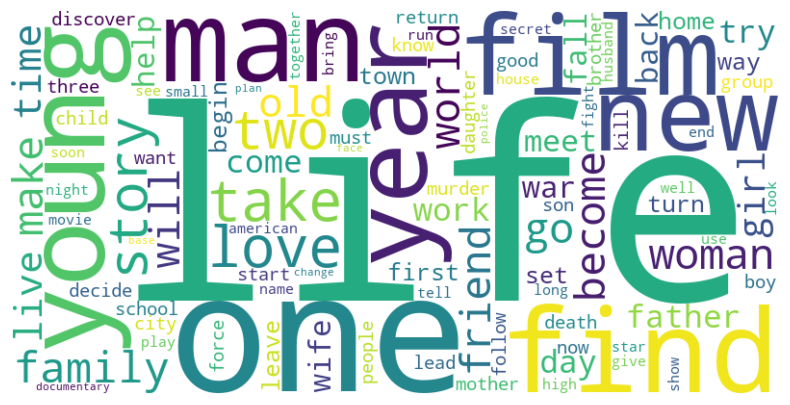

In [17]:
wordcloud_params = {
    'width': 800,
    'height': 400,
    'background_color': 'white', 
    'max_words': 100,
    'collocations': False,
}
wordcloud = WordCloud(**wordcloud_params).generate(overviews_str)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### User input

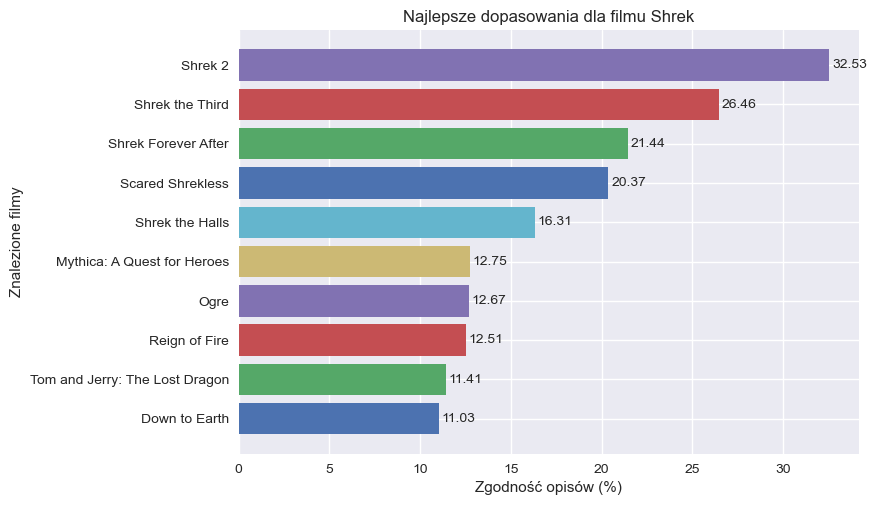

Do widzenia.


In [18]:
def run() -> None:
    while True:
        command = input('Znajdź film: ')
        match command.split():
            case ['quit', *items]:
                print('Do widzenia.')
                break
            case [*items]:
                title = ' '.join(items)
                top_matches = find_similar(title=title)
                if top_matches:
                    create_chart(matches=top_matches, title=title, savetofile=True)
                else:
                    suggest_titles(title=title)

run()

<hr style="border-top: 2px solid white">

<style>
    * {
      font-family: 'Consolas', monospace;
    }
    thead {
        background-color: #2596be;
    }
    tr:nth-child(even) {
      background-color: rgb(37, 150, 190);
    }
</style>